In [1]:
%load_ext autoreload
%autoreload 2

from lgnpy.CEandSC.lgn_statistics import LGN, lgn_statistics, get_edge_maps
from oads_access.utils import loadmat
import numpy as np
import matplotlib.pyplot as plt
from pytorch_utils.pytorch_utils import ToRetinalGanglionCellSampling
import cv2
import os

/home/niklas/anaconda3/envs/oads/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libc10_cuda.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
def get_field_of_view(lgn, imsize, viewing_dist):
    # if viewing_dist is None:
    #     viewing_dist = lgn.get_attr('viewing_dist')
    dot_pitch = lgn.get_attr('dot_pitch')
    fov_beta = lgn.get_attr('fov_beta')
    fov_gamma = lgn.get_attr('fov_gamma')

    fovx = round(imsize[1]/2)          # x-pixel loc. of fovea center
    fovy = round(imsize[0]/2)          # y-pixel loc. of fovea center
    # ex and ey are the x- and y- offsets of each pixel compared to
    # the point of focus (fovx,fovy) in pixels.
    ex, ey = np.meshgrid(np.arange(start=-fovx+1, stop=imsize[1]-fovx+1),
                        np.arange(start=-fovy+1, stop=imsize[0]-fovy+1))
    # eradius is the radial distance between each point and the point
    # of gaze.  This is in meters.
    eradius = dot_pitch * np.sqrt(ex**2+ey**2)
    del ex, ey
    # calculate ec, the eccentricity from the foveal center, for each
    # point in the image.  ec is in degrees.
    ec = 180*np.arctan(eradius / viewing_dist)/np.pi
    # select the pixels that fall within the input visual field of view
    imfovbeta = (ec < fov_beta)
    imfovgamma = (ec < fov_gamma)

    return imfovbeta, imfovgamma

In [3]:
threshold_lgn = loadmat('/home/niklas/projects/lgnpy/ThresholdLGN.mat')
threshold_lgn = threshold_lgn['ThresholdLGN']

Could not load mat file with mat73 - trying to load with scipy.io.loadmat!


In [4]:
lgn = LGN(config={'dot_pitch':0.000276, 'fov_gamma': 5}, default_config_path='/home/niklas/projects/lgnpy/lgnpy/CEandSC/default_config.yml')
# {'dot_pitch':0.000276, 'fov_gamma': 5}

In [56]:
RGC = ToRetinalGanglionCellSampling(out_size=1374)

In [6]:
folder = '/home/niklas/projects/data/oads/oads_arw/tiff'
filename = '0001515331a1c8c0.tiff'

In [53]:
im = cv2.imread(os.path.join(folder, filename)) # Always loads images in BGR order
im = im[:,:,::-1] # Reverse order to RGB
im = cv2.resize(im, (0,0), fx=1/4, fy=1/4) 

In [57]:
rgc_input = RGC(im)

In [58]:
im.shape

(918, 1374, 3)

In [59]:
rgc_input.shape

(1374, 1374, 3)

In [10]:
back_RGC = ToRetinalGanglionCellSampling(out_size=1374, decomp=1)
backsampled_input = back_RGC(rgc_input)

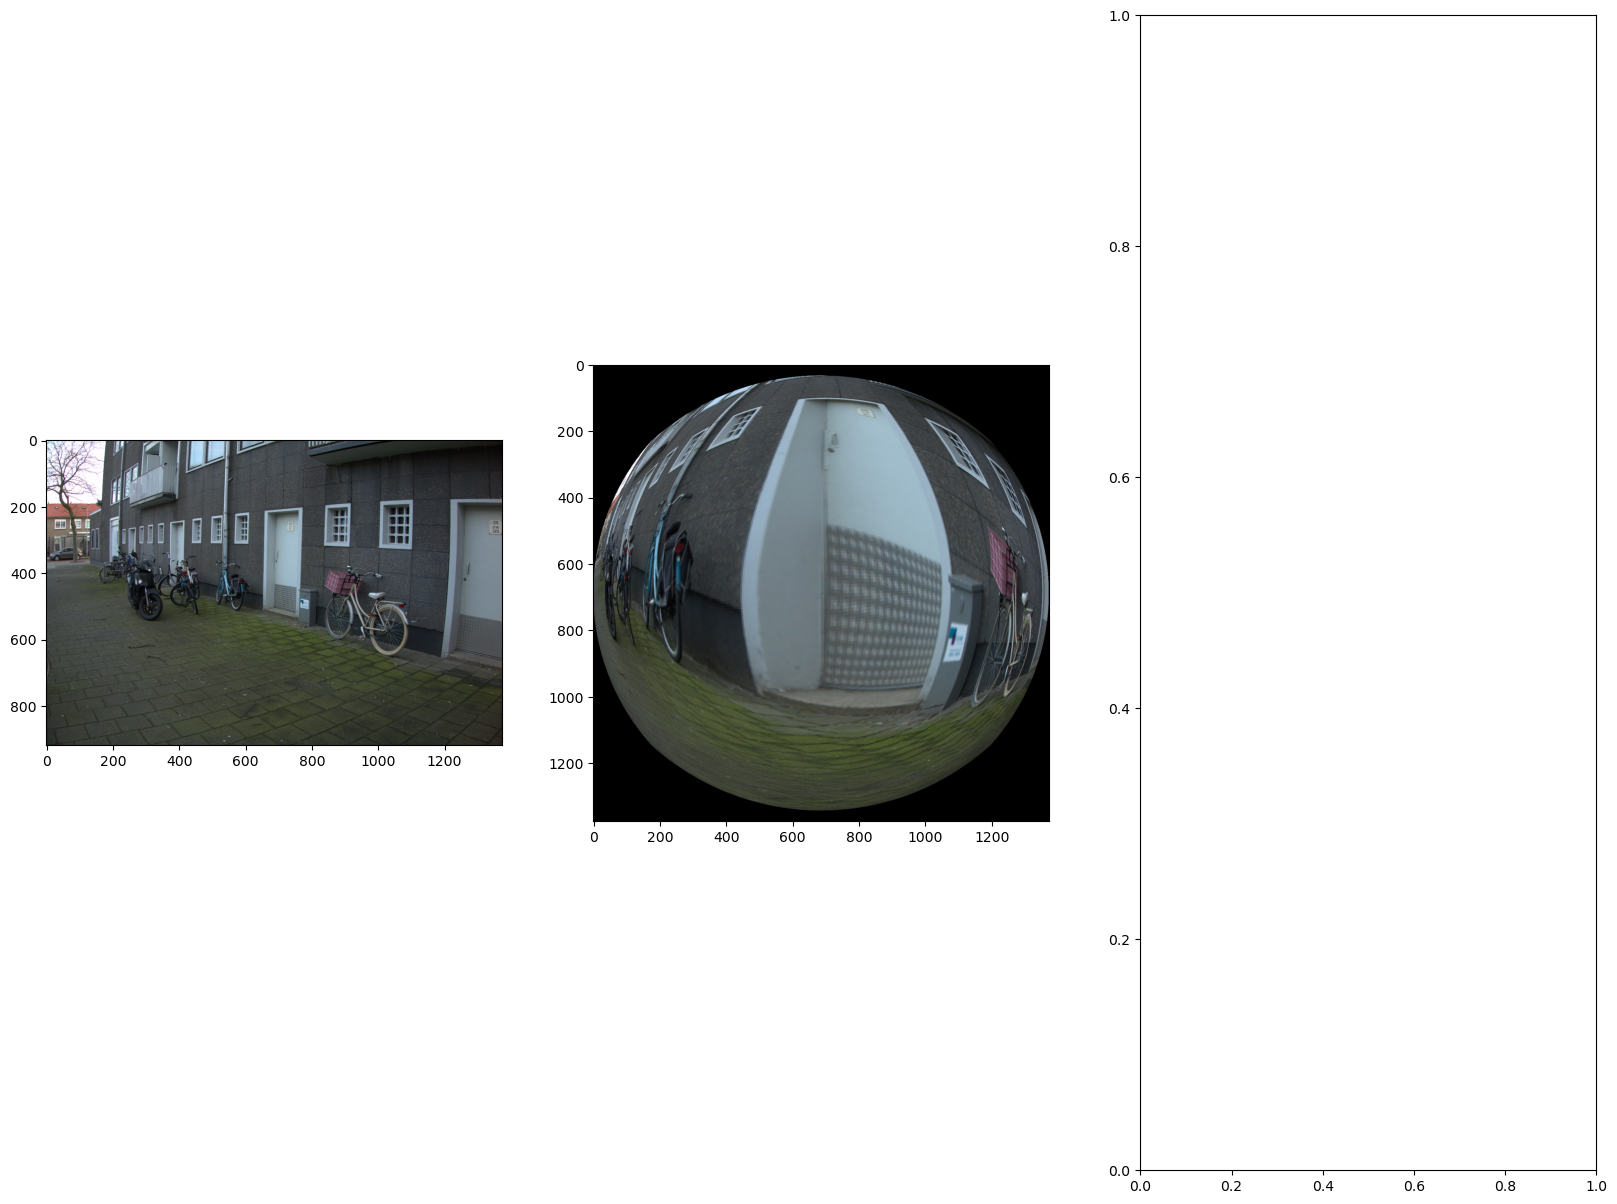

In [60]:
fig, ax = plt.subplots(1,3, figsize=(20,15))
ax[0].imshow(im)
ax[1].imshow(rgc_input)
# ax[2].imshow(backsampled_input)

plt.show()

In [67]:
imfovbeta, imfovgamma = get_field_of_view(lgn=lgn, imsize=im.shape[:2], viewing_dist=1)
_lgn = LGN(config={'dot_pitch':0.000276, 'fov_gamma': 20, 'fov_beta': 3}, default_config_path='/home/niklas/projects/lgnpy/lgnpy/CEandSC/default_config.yml')
rgc_imfovbeta, rgc_imfovgamma = get_field_of_view(lgn=_lgn, imsize=rgc_input.shape[:2], viewing_dist=2)

In [62]:
par1, par2, par3, mag1, mag2, mag3 = get_edge_maps(im=im, threshold_lgn=threshold_lgn, cache=False, file_name='', IMTYPE=2, imsize=im.shape[:2], lgn=lgn)
_lgn = LGN(config={'dot_pitch':0.000276, 'fov_gamma': 20, 'fov_beta': 1.5}, default_config_path='/home/niklas/projects/lgnpy/lgnpy/CEandSC/default_config.yml')
rgc_par1, rgc_par2, rgc_par3, rgc_mag1, rgc_mag2, rgc_mag3 = get_edge_maps(im=rgc_input, threshold_lgn=threshold_lgn, cache=False, file_name='', IMTYPE=2, imsize=rgc_input.shape[:2], lgn=_lgn)

In [49]:
lgn_RGC = ToRetinalGanglionCellSampling(out_size=max(par1.shape))
par1_rgc_after = lgn_RGC(par1, dtype_prepare=float)
# mag_rgc_after = RGC(np.dstack((mag1,mag2,mag3)))

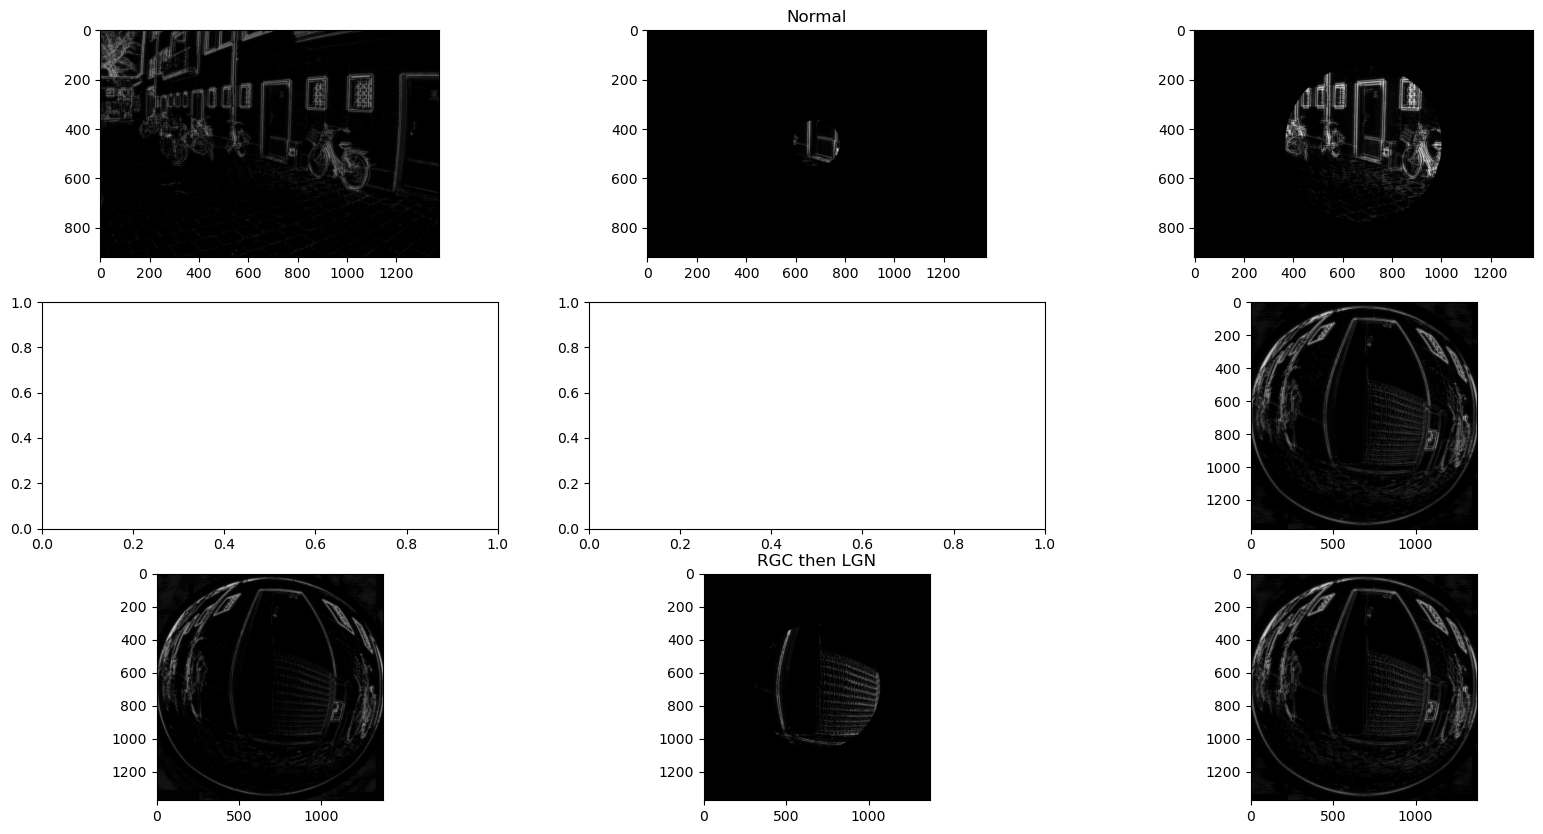

: 

In [68]:
fig, ax = plt.subplots(3,3, figsize=(20,10))
ax[0, 0].imshow(par1, cmap='gray')
# ax[0, 1].imshow(np.where(np.dstack((imfovbeta, imfovbeta, imfovbeta)), im, 0))
# ax[0, 2].imshow(np.where(np.dstack((imfovgamma, imfovgamma, imfovgamma)), im, 0))
ax[0, 1].imshow(np.where(imfovbeta, par1, 0), cmap='gray')
ax[0, 2].imshow(np.where(imfovgamma, mag1, 0), cmap='gray')
ax[0, 1].set_title('Normal')

# ax[1, 0].imshow(par1_rgc_after, cmap='gray')
# ax[1, 1].imshow(np.where(rgc_imfovbeta, par1_rgc_after, 0), cmap='gray')
# # ax[1, 2].imshow(np.where(rgc_imfovgamma, mag_rgc_after[:,:,0], 0), cmap='gray')
# ax[1, 1].set_title('LGN then RGC')


ax[2, 0].imshow(rgc_par1, cmap='gray')
# ax[2, 1].imshow(np.where(np.dstack((rgc_imfovbeta, rgc_imfovbeta, rgc_imfovbeta)), rgc_input, 0), cmap='gray')
# ax[2, 2].imshow(np.where(np.dstack((rgc_imfovgamma, rgc_imfovgamma, rgc_imfovgamma)), rgc_input, 0), cmap='gray')
ax[2, 1].imshow(np.where(rgc_imfovbeta, rgc_par1, 0), cmap='gray')
ax[1, 2].imshow(rgc_mag1, cmap='gray')
ax[2, 2].imshow(np.where(rgc_imfovgamma, rgc_mag1, 0), cmap='gray')
ax[2, 1].set_title('RGC then LGN')

plt.show()

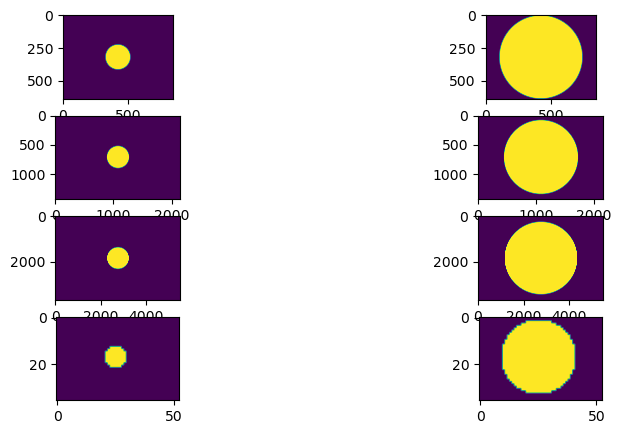

In [ ]:
imfovbeta, imfovgamma = get_field_of_view(lgn=lgn, imsize=(640, 840), viewing_dist=1)
imfovbeta1, imfovgamma1 = get_field_of_view(lgn=lgn, imsize=(1440, 2155), viewing_dist=2)
imfovbeta2, imfovgamma2 = get_field_of_view(lgn=lgn, imsize=(3672, 5496), viewing_dist=5)
imfovbeta3, imfovgamma3 = get_field_of_view(lgn=lgn, imsize=(1440//40, 2155//40), viewing_dist=2/40)
fig, ax = plt.subplots(4,2, figsize=(10,5))

ax[0, 0].imshow(imfovbeta)
ax[0, 1].imshow(imfovgamma)
ax[1, 0].imshow(imfovbeta1)
ax[1, 1].imshow(imfovgamma1)
ax[2, 0].imshow(imfovbeta2)
ax[2, 1].imshow(imfovgamma2)
ax[3, 0].imshow(imfovbeta3)
ax[3, 1].imshow(imfovgamma3)

plt.show()

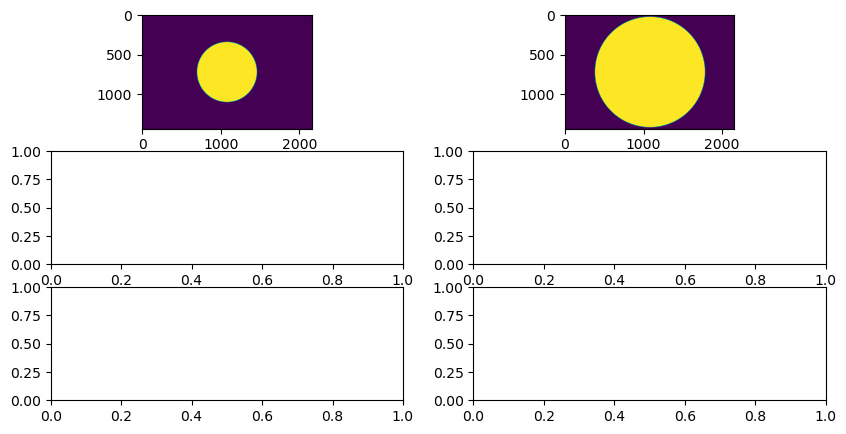

In [22]:
_lgn = LGN(config={'dot_pitch':0.000276, 'fov_gamma': 5.5, 'fov_beta': 3}, default_config_path='/home/niklas/projects/lgnpy/lgnpy/CEandSC/default_config.yml')
imfovbeta1, imfovgamma1 = get_field_of_view(lgn=_lgn, imsize=(1440, 2155), viewing_dist=2)
# imfovbeta2, imfovgamma2 = get_field_of_view(lgn=_lgn, imsize=(1440//4, 2155//4), viewing_dist=2/4)
# imfovbeta3, imfovgamma3 = get_field_of_view(lgn=_lgn, imsize=(1440//10, 2155//10), viewing_dist=2/10)

fig, ax = plt.subplots(3,2, figsize=(10,5))

ax[0, 0].imshow(imfovbeta1)
ax[0, 1].imshow(imfovgamma1)
# ax[1, 0].imshow(imfovbeta2)
# ax[1, 1].imshow(imfovgamma2)
# ax[2, 0].imshow(imfovbeta3)
# ax[2, 1].imshow(imfovgamma3)

plt.show()

In [ ]:
imfovbeta.shape, imfovgamma.shape

((640, 840), (640, 840))